In [111]:
from IPython.utils import io
import os
import subprocess
import tqdm.notebook

TQDM_BAR_FORMAT = '{l_bar}{bar}| {n_fmt}/{total_fmt} [elapsed: {elapsed} remaining: {remaining}]'


In [112]:
import torch
from botorch import fit_gpytorch_model
from botorch.acquisition import UpperConfidenceBound
from botorch.models import SingleTaskGP
from botorch.optim import optimize_acqf
from gpytorch.mlls import ExactMarginalLogLikelihood
from gpytorch.kernels import RBFKernel, ScaleKernel
import numpy as np
import pandas as pd
from scipy.special import softmax
import matplotlib.pyplot as plt
import seaborn as sns
from botorch.models import SaasFullyBayesianSingleTaskGP
from gpytorch.kernels import MaternKernel, ScaleKernel
from botorch.acquisition import ExpectedImprovement
from gpytorch import constraints

# 目的関数の用意 (Rosenbrock関数)

In [113]:
def styblinski_tang(x):
    indices = [2, 3, 5, 7, 9]
    x_selected = x[..., indices]
    return 0.5 * torch.sum(x_selected ** 4 - 16 * x_selected ** 2 + 5 * x_selected, dim=-1)

In [114]:
# styblinski_tang関数の最適解
global_optimum = -39.16599 * 5

# 初期点の生成関数

In [115]:
def generate_initial_points(n_initial, dim, bounds):
    return torch.rand(n_initial, dim) * (bounds[1] - bounds[0]) + bounds[0]

# モデル作成関数


In [116]:
def create_model(train_X, train_Y):
    kernel = ScaleKernel(RBFKernel(ard_num_dims=train_X.shape[-1], noise_constraint=1e-5))
    model = SingleTaskGP(train_X, train_Y, covar_module=kernel)
    return model

# ドロップアウトベイズクラス

In [117]:
class DropoutMixBO:
    def __init__(self, dim, active_dim, bounds, n_initial, obj_function, dropout_prob=0.1):
        # クラスの初期化。パラメータを設定するよ
        self.dim = dim  # 全体の次元数
        self.active_dim = active_dim  # 活性化する次元数
        self.bounds = bounds  # 各次元の探索範囲
        self.obj_function = obj_function  # 最適化したい目的関数
        self.dropout_prob = dropout_prob  # ドロップアウトの確率
        self.X = generate_initial_points(n_initial, dim, bounds)  # 初期点を生成
        self.Y = self.obj_function(self.X)  # 初期点での目的関数の値を計算
        self.best_f = self.Y.min().item()  # 現在の最良の目的関数値
        self.best_x = self.X[self.Y.argmin()]  # 現在の最良の解
        self.eval_history = [self.best_f] * n_initial  # 評価履歴を初期化

    def optimize(self, n_iter):
        for _ in range(n_iter):  # 指定された回数だけ最適化を繰り返すよ
            # 全次元からランダムにactive_dim個選ぶ
            active_dims = np.random.choice(self.dim, self.active_dim, replace=False)

            train_X = self.X[:, active_dims]  # 選んだ次元のデータだけ抽出
            train_Y = self.Y.unsqueeze(-1)  # Yの形状を調整
            model = create_model(train_X, train_Y)  # GPモデルを作成
            mll = ExactMarginalLogLikelihood(model.likelihood, model)  # 尤度関数を定義
            fit_gpytorch_model(mll)  # モデルを学習

            UCB = UpperConfidenceBound(model, beta=0.1)  # 獲得関数を定義
            bounds_active = torch.stack([self.bounds[0][active_dims], self.bounds[1][active_dims]])  # 活性化次元の探索範囲
            candidate, _ = optimize_acqf(  # 獲得関数を最適化して次の候補点を見つける
                UCB, bounds=bounds_active, q=1, num_restarts=5, raw_samples=20,
            )

            x_new = torch.zeros(self.dim)  # 新しい候補点を初期化
            if np.random.random() < self.dropout_prob:  # ドロップアウトを適用するかどうか決める
                x_new[active_dims] = candidate.squeeze()  # 活性化次元に候補点の値を設定
                inactive_dims = np.setdiff1d(range(self.dim), active_dims)  # 非活性化次元を特定
                x_new[inactive_dims] = (torch.rand(len(inactive_dims))  # 非活性化次元にランダムな値を設定
                                        * (self.bounds[1][inactive_dims] - self.bounds[0][inactive_dims])
                                        + self.bounds[0][inactive_dims])
            else:
                x_new[active_dims] = candidate.squeeze()  # 活性化次元に候補点の値を設定
                x_new[np.setdiff1d(range(self.dim), active_dims)] = self.best_x[  # 非活性化次元に最良解の値を設定
                    np.setdiff1d(range(self.dim), active_dims)]

            y_new = self.obj_function(x_new.unsqueeze(0))  # 新しい候補点での目的関数値を計算

            self.X = torch.cat([self.X, x_new.unsqueeze(0)])  # データセットに新しい点を追加
            self.Y = torch.cat([self.Y, y_new])  # 目的関数値のリストに新しい値を追加

            if y_new < self.best_f:  # もし新しい点が今までの最良値より良ければ
                self.best_f = y_new.item()  # 最良値を更新
                self.best_x = x_new  # 最良解を更新

            self.eval_history.append(self.best_f)  # 評価履歴に現在の最良値を追加

        return self.best_x, self.best_f  # 最適化が終わったら最良解と最良値を返す

# REMBO

In [118]:
class REMBO:
    def __init__(self, high_dim, low_dim, bounds, n_initial, obj_function):
        assert high_dim >= low_dim, "high_dim must be greater than or equal to low_dim"

        self.high_dim = high_dim
        self.low_dim = low_dim
        self.bounds = bounds
        self.obj_function = obj_function
        
        # すべてのテンソルをdouble型に変更
        self.A = torch.randn(high_dim, low_dim, dtype=torch.double)
        
        self.X_low = (torch.randn(n_initial, low_dim, dtype=torch.double) * 2 - 1)
        
        self.X_high = torch.clamp(self.X_low @ self.A.t(), bounds[0], bounds[1])
        assert self.X_high.shape == (n_initial, high_dim), f"Expected shape {(n_initial, high_dim)}, but got {self.X_high.shape}"
        
        self.Y = self.obj_function(self.X_high)
        
        self.best_f = self.Y.min().item()
        self.best_x = self.X_high[self.Y.argmin()]
        self.eval_history = [self.best_f] * n_initial

    def optimize(self, n_iter):
        for _ in range(n_iter):
            train_X_low = self.X_low
            train_Y = self.Y.unsqueeze(-1)
            model = SingleTaskGP(train_X_low, train_Y)
            mll = ExactMarginalLogLikelihood(model.likelihood, model)
            fit_gpytorch_model(mll)

            UCB = UpperConfidenceBound(model, beta=0.1)
            
            bounds_low = torch.stack([torch.ones(self.low_dim, dtype=torch.double) * -1, torch.ones(self.low_dim, dtype=torch.double)])
            candidate_low, _ = optimize_acqf(
                UCB, bounds=bounds_low, q=1, num_restarts=5, raw_samples=20,
            )

            x_high = torch.clamp(candidate_low @ self.A.t(), self.bounds[0], self.bounds[1])
            y_new = self.obj_function(x_high)

            self.X_low = torch.cat([self.X_low, candidate_low])
            self.X_high = torch.cat([self.X_high, x_high])
            self.Y = torch.cat([self.Y, y_new])

            if y_new < self.best_f:
                self.best_f = y_new.item()
                self.best_x = x_high.squeeze()

            self.eval_history.append(self.best_f)

        return self.best_x, self.best_f

# BC-UCBアルゴリズムを取り入れたDropoutMixBO_BCUCBクラス

In [119]:
class DropoutMixBO_BC_UCB:
    def __init__(self, dim, active_dim, bounds, n_initial, obj_function, dropout_prob=0.0, epsilon=0.1,
                 temperature=1e-3, reset_interval=1000, learning_rate=0.005, initial_beta=2.0, annealing_rate=1000):
        # クラスの初期化
        self.dim = dim
        self.active_dim = active_dim
        self.bounds = bounds
        self.dropout_prob = dropout_prob
        self.obj_function = obj_function
        self.epsilon = epsilon
        self.temperature = temperature
        self.reset_interval = reset_interval
        self.iteration = 0
        self.learning_rate = learning_rate
        self.initial_beta = initial_beta
        self.annealing_rate = annealing_rate

        # 初期点の生成と評価
        initial_X = generate_initial_points(n_initial, dim, bounds)
        initial_Y = obj_function(initial_X)

        self.X = initial_X.double()
        self.Y = initial_Y.double()

        self.best_f = self.Y.min().item()
        self.best_x = self.X[self.Y.argmin()]
        self.eval_history = [self.best_f] * n_initial
        self.improvement_history = []

        self.arm_rewards = np.zeros(dim)
        self.arm_counts = np.zeros(dim)
        self.total_pulls = 0
        self.dim_importance = np.ones(dim) / dim
        self.dim_sensitivity = np.zeros(dim)

        self.arm_selection_history = []
        self.sigma_history = []


    def select_active_dims(self):
        # 活性化する次元を選択
        self.iteration += 1

        # UCBスコアに基づいて選択
        ucb_scores = self.calculate_ucb_scores()

        # ソフトマックスの適用
        probabilities = softmax(ucb_scores / self.temperature)
        probabilities = np.nan_to_num(probabilities, nan=1.0 / self.dim, posinf=1.0, neginf=0.0)
        probabilities = np.clip(probabilities, 1e-10, 1)
        probabilities /= probabilities.sum()

        selected_arms = np.random.choice(self.dim, self.active_dim, replace=False, p=probabilities)

        # 選択された次元を記録
        arm_selection = np.zeros(self.dim)
        arm_selection[selected_arms] = 1
        self.arm_selection_history.append(arm_selection)

        return selected_arms

    def calculate_ucb_scores(self):
        # UCBスコアを計算
        exploration_term = np.sqrt(2 * np.log(self.total_pulls + 1) / (self.arm_counts + 1e-5))
        exploitation_term = self.arm_rewards / (self.arm_counts + 1e-5)

        # アニーリングによるβの調整
        beta = self.initial_beta * np.exp(-self.iteration / self.annealing_rate)

        ucb_scores = exploitation_term + beta * exploration_term
        return ucb_scores * self.dim_importance

    def calculate_dimension_sensitivity(self, new_x, new_y):
        # 新しいデータポイントを追加
        X_new = torch.cat([self.X, new_x.unsqueeze(0)], dim=0)
        Y_new = torch.cat([self.Y, new_y])

        self.X = X_new
        self.Y = Y_new

        # NumPy配列に変換
        X_np = self.X.cpu().numpy()
        Y_np = self.Y.cpu().numpy()

        sensitivities = np.zeros(self.dim)
        for i in range(self.dim):
            sorted_indices = np.argsort(X_np[:, i])
            sorted_x = X_np[sorted_indices, i]
            sorted_y = Y_np[sorted_indices]
            dx = np.diff(sorted_x)
            dy = np.diff(sorted_y)
            nonzero_dx = dx != 0
            diffs = np.zeros_like(dx)
            diffs[nonzero_dx] = dy[nonzero_dx] / dx[nonzero_dx]
            sensitivities[i] = np.mean(np.abs(diffs))

        total_sensitivity = np.sum(sensitivities) + 1e-10
        new_sensitivity = sensitivities / total_sensitivity

        # 指数移動平均で感度を更新
        alpha = 0.1
        self.dim_sensitivity = alpha * new_sensitivity + (1 - alpha) * self.dim_sensitivity

    def update_bandit(self, selected_dims, y_new):
        # バンディットの更新
        improvement = max(0, self.best_f - y_new)
        self.improvement_history.append(improvement)
        relative_improvement = improvement / (abs(self.best_f) + 1e-8)

        self.total_pulls += 1
        for dim in selected_dims:
            self.arm_counts[dim] += 1
            arm_contribution = relative_improvement * self.dim_sensitivity[dim] / (
                    sum(self.dim_sensitivity[selected_dims]) + 1e-10)
            self.arm_rewards[dim] += arm_contribution

        # 重要度の更新
        importance_update = self.dim_sensitivity / (np.sum(self.dim_sensitivity) + 1e-10)
        self.dim_importance = (1 - self.learning_rate) * self.dim_importance + self.learning_rate * importance_update
        self.dim_importance /= np.sum(self.dim_importance)

        # 報酬の正規化
        self.arm_rewards = (self.arm_rewards - np.mean(self.arm_rewards)) / (np.std(self.arm_rewards) + 1e-8)

    def optimize(self, n_iter):
        # 最適化のメインループ
        for _ in range(n_iter):
            # 活性化する次元を選択
            active_dims = self.select_active_dims()

            # モデルの学習データを準備
            train_X = self.X[:, active_dims]
            train_Y = self.Y.unsqueeze(-1)

            # ガウス過程モデルの作成とフィッティング
            model = create_model(train_X, train_Y)
            mll = ExactMarginalLogLikelihood(model.likelihood, model)
            fit_gpytorch_model(mll)

            # Expected Improvement (EI) 獲得関数の定義
            EI = ExpectedImprovement(model, best_f=self.best_f, maximize=False)
            bounds_active = torch.stack([self.bounds[0][active_dims], self.bounds[1][active_dims]]).double()

            # 獲得関数の最適化
            candidate, _ = optimize_acqf(
                EI, bounds=bounds_active, q=1, num_restarts=10, raw_samples=100,
                options={"maxiter": 200, "batch_limit": 5}
            )

            # 新しい候補点を構築
            x_new = torch.zeros(self.dim, dtype=torch.double)
            x_new[active_dims] = candidate.squeeze()
            x_new[np.setdiff1d(range(self.dim), active_dims)] = self.best_x[
                np.setdiff1d(range(self.dim), active_dims)]

            # 目的関数の評価
            y_new = self.obj_function(x_new.unsqueeze(0))

            # 感度の更新
            self.calculate_dimension_sensitivity(x_new, y_new)

            # 予測標準偏差の取得
            with torch.no_grad():
                pred = model(candidate)
            sigma = pred.stddev.item()
            self.sigma_history.append(sigma)

            # バンディットの更新
            self.update_bandit(active_dims, y_new.item())
            
            # 最良値の更新
            if y_new.item() < self.best_f:
                self.best_f = y_new.item()
                self.best_x = x_new

            # 評価履歴の更新
            self.eval_history.append(self.best_f)

        # 次元選択の履歴をDataFrameに変換
        self.arm_selection_df = pd.DataFrame(self.arm_selection_history,
                                             columns=[f'Arm_{i}' for i in range(self.dim)])
        self.arm_selection_df.index.name = 'Iteration'

        return self.best_x, self.best_f

    # 結果の保存と可視化
    def save_arm_selection_history(self, filename):
        self.arm_selection_df.to_csv(filename)

    def plot_sigma_history(self):
        plt.figure(figsize=(12, 6))
        plt.plot(range(1, len(self.sigma_history) + 1), self.sigma_history)
        plt.xlabel('Iteration')
        plt.ylabel('Predicted Standard Deviation')
        plt.title('Predicted Standard Deviation vs Iteration')
        plt.grid(True)
        plt.show()

    def plot_dim_importance(self):
        plt.figure(figsize=(12, 6))
        plt.bar(range(self.dim), self.dim_importance)
        plt.xlabel('Dimension')
        plt.ylabel('Importance')
        plt.title('Dimension Importance')
        plt.xticks(range(self.dim))
        plt.grid(True)
        plt.show()

    def plot_dim_sensitivity(self):
        plt.figure(figsize=(12, 6))
        plt.bar(range(self.dim), self.dim_sensitivity)
        plt.xlabel('Dimension')
        plt.ylabel('Sensitivity')
        plt.title('Dimension Sensitivity')
        plt.xticks(range(self.dim))
        plt.grid(True)
        plt.show()

# 最適化の実行


In [120]:
dim = 10
active_dim = 5
bounds = torch.tensor([[-5.0] * dim, [5.0] * dim])
n_initial = 200
n_iter = 1500

In [121]:
dropout_bo_mix = DropoutMixBO(dim, active_dim, bounds, n_initial, styblinski_tang, dropout_prob=0.1)
dropout_bo_copy = DropoutMixBO(dim, active_dim, bounds, n_initial, styblinski_tang, dropout_prob=0.0)
dropout_bo_random = DropoutMixBO(dim, active_dim, bounds, n_initial, styblinski_tang, dropout_prob=1.0)
dropout_bandit_bc_ucb = DropoutMixBO_BC_UCB(dim, active_dim, bounds, n_initial, styblinski_tang, dropout_prob=0.0)
rembo = REMBO(dim, active_dim, bounds, n_initial, styblinski_tang)

In [122]:
try:
  with tqdm.notebook.tqdm(total=100, bar_format=TQDM_BAR_FORMAT) as pbar:
    with io.capture_output() as captured:
      dropout_mix_best_x , dropout_mix_best_f = dropout_bo_mix.optimize(n_iter)
      pbar.update(20)
      dropout_copy_best_x , dropout_copy_best_f = dropout_bo_copy.optimize(n_iter)
      pbar.update(20)
      dropout_random_best_x , dropout_random_best_f = dropout_bo_random.optimize(n_iter)
      pbar.update(20)
      rembo_best_x, rembo_best_f = rembo.optimize(n_iter)
      pbar.update(20) 
      pbar.update(10)
      dropout_bandit_bc_ucb_best_x, dropout_bandit_bc_ucb_best_f = dropout_bandit_bc_ucb.optimize(n_iter)
      dropout_bandit_bc_ucb.save_arm_selection_history('dropout_bandit_bc_ucb_arm_selection_binary.csv')
      pbar.update(10)
    
except subprocess.CalledProcessError:
  print(captured)
  raise

  0%|          | 0/100 [elapsed: 00:00 remaining: ?]

## アームの履歴 BC_UCBのバンディット

           Arm_0  Arm_1  Arm_2  Arm_3  Arm_4  Arm_5  Arm_6  Arm_7  Arm_8  \
Iteration                                                                  
0            0.0    0.0    0.0    1.0    0.0    1.0    1.0    1.0    1.0   
1            1.0    1.0    0.0    1.0    1.0    1.0    0.0    0.0    0.0   
2            0.0    1.0    0.0    0.0    1.0    0.0    0.0    1.0    1.0   
3            0.0    1.0    1.0    0.0    1.0    0.0    0.0    0.0    1.0   
4            1.0    1.0    1.0    0.0    0.0    0.0    1.0    1.0    0.0   

           Arm_9  
Iteration         
0            0.0  
1            0.0  
2            1.0  
3            1.0  
4            0.0  


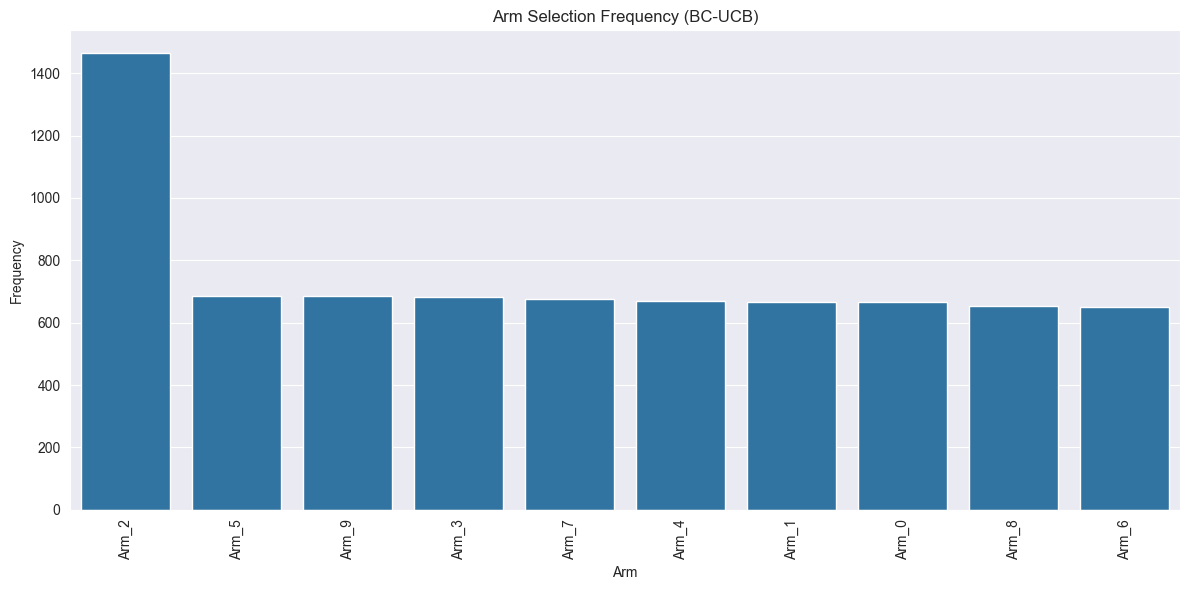

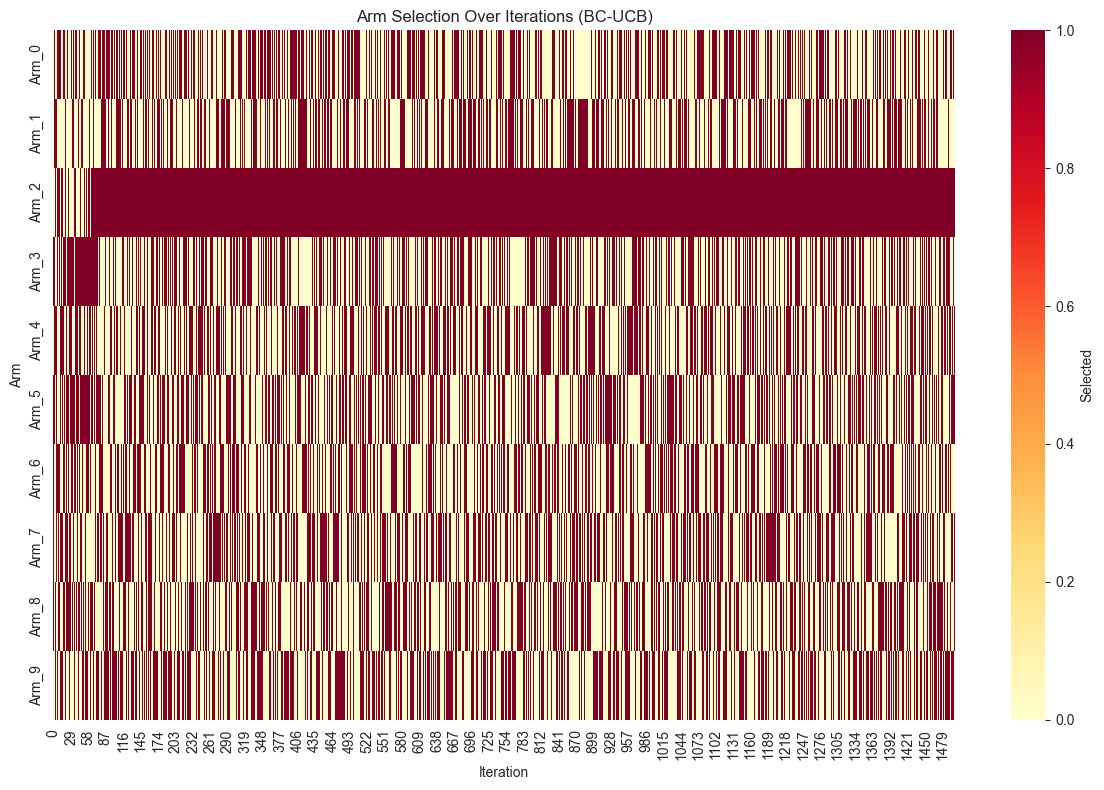

In [123]:
# Load the saved CSV file
df = pd.read_csv("dropout_bandit_bc_ucb_arm_selection_binary.csv", index_col="Iteration")

# Display the first few rows of the DataFrame
print(df.head())

# Calculate arm selection frequency
arm_freq = df.sum().sort_values(ascending=False)

# Create a bar plot of arm selection frequency
plt.figure(figsize=(12, 6))
sns.barplot(x=arm_freq.index, y=arm_freq.values)
plt.title("Arm Selection Frequency (BC-UCB)")
plt.xlabel("Arm")
plt.ylabel("Frequency")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Create a heatmap of arm selection over iterations
plt.figure(figsize=(12, 8))
sns.heatmap(df.T, cmap="YlOrRd", cbar_kws={'label': 'Selected'})
plt.title("Arm Selection Over Iterations (BC-UCB)")
plt.xlabel("Iteration")
plt.ylabel("Arm")
plt.tight_layout()
plt.show()

## Dropout_Banditのimprovementのプロット

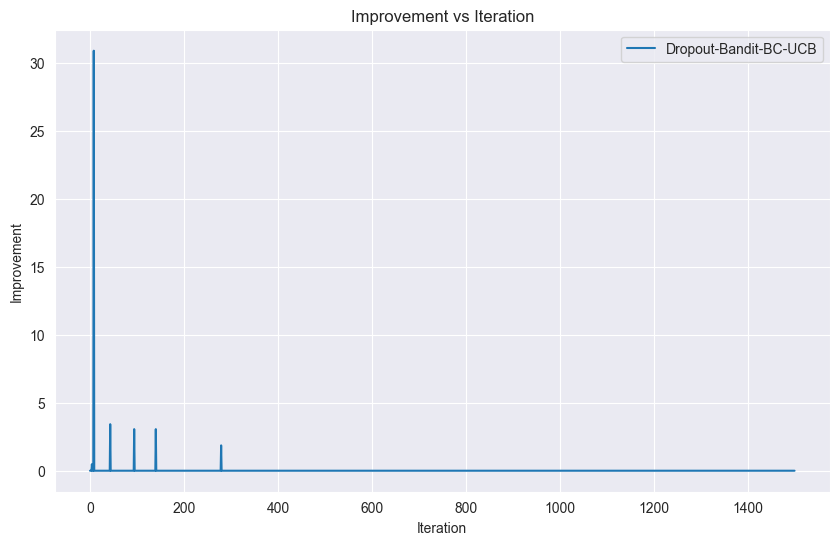

In [124]:
plt.figure(figsize=(10, 6))
plt.plot(range(len(dropout_bandit_bc_ucb.improvement_history)), dropout_bandit_bc_ucb.improvement_history, label='Dropout-Bandit-BC-UCB')
plt.xlabel('Iteration')
plt.ylabel('Improvement')
plt.title('Improvement vs Iteration')
plt.legend()
plt.grid(True)
plt.show()

## Dropout_Banditのsigmaのプロット

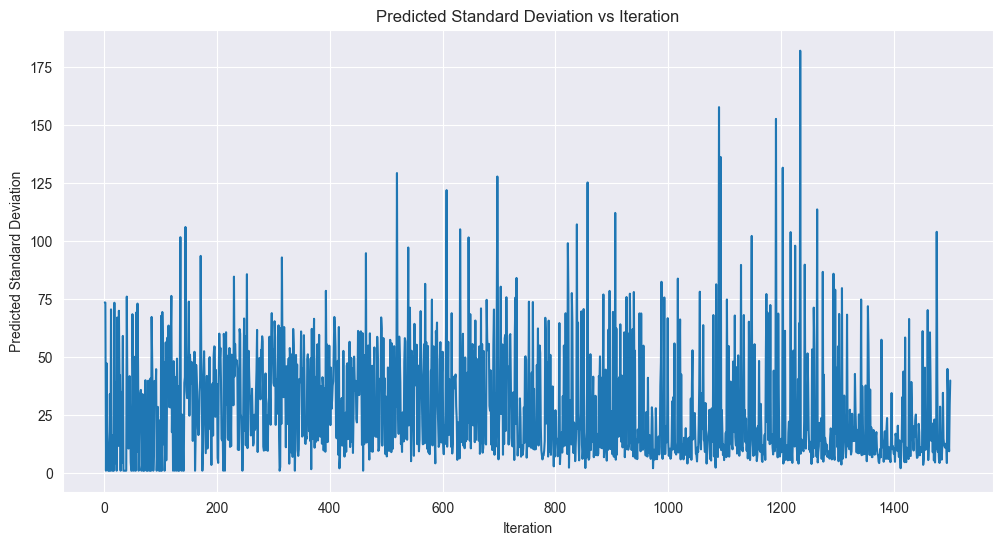

In [125]:
dropout_bandit_bc_ucb.plot_sigma_history()

## Dropout_Banditの次元重要度のプロット

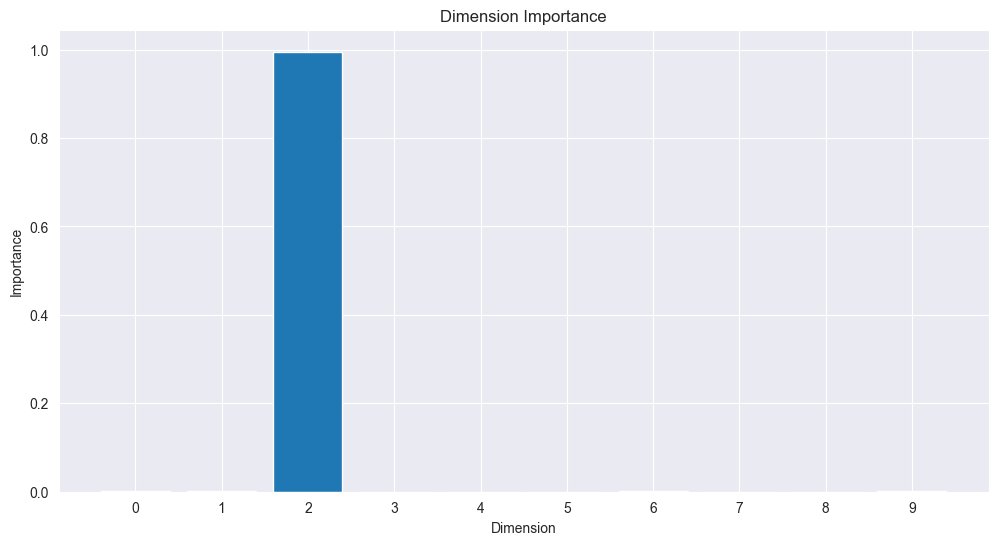

In [126]:
dropout_bandit_bc_ucb.plot_dim_importance()

# 結果のプロット

C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 12288 (\N{IDEOGRAPHIC SPACE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


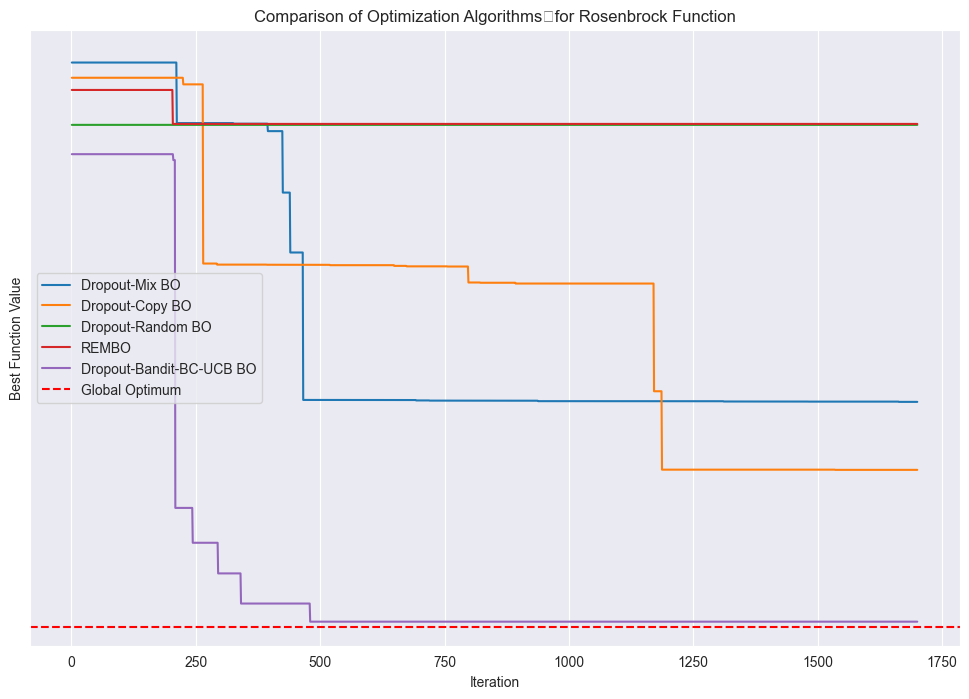

In [127]:
plt.figure(figsize=(12, 8))
plt.plot(range(1, n_initial + n_iter + 1), dropout_bo_mix.eval_history, label='Dropout-Mix BO')
plt.plot(range(1, n_initial + n_iter + 1), dropout_bo_copy.eval_history, label='Dropout-Copy BO')
plt.plot(range(1, n_initial + n_iter + 1), dropout_bo_random.eval_history, label='Dropout-Random BO')
plt.plot(range(1, n_initial + n_iter + 1), rembo.eval_history, label='REMBO')
plt.plot(range(1, n_initial + n_iter + 1), dropout_bandit_bc_ucb.eval_history, label='Dropout-Bandit-BC-UCB BO')
plt.axhline(y=global_optimum, color='r', linestyle='--', label='Global Optimum')
plt.xlabel('Iteration')
plt.ylabel('Best Function Value')
plt.title('Comparison of Optimization Algorithms　for Rosenbrock Function')
plt.legend()
plt.yscale('symlog')
plt.grid(True)
plt.show()